# Input data analysis for Plasmid Comparison

The following document contains the details of the analysis of the data to be used for the Plasmid Comparison method. We use the results from two plasmid assembly tools, HyAsP and MOB-suite. For any given isolate, we obtain a set of plasmids each from both tools. Each plasmid is obained as a collection of contigs, possibly with repeats.
For each isolate, we plan to develop a method to compare the set of plasmids and compute how close the sets are to each other.


## Method

The method takes two sets of plasmids as input. Each plasmid is a collection of contigs. For a given isolate, a contig will be represented by the same id in both methods. It is possible that a set of plasmids contains multiple copies of the same contig. We first assign labels to each copy of a contig before comparing the two sets of plasmids. If there are any contigs that are present only in one set of plasmids, this implies that the  other tool did not consider these contigs as part of any plasmid in the output.

The method entails splitting plasmids from one set (from one tool) to yield an intermediate set of "plasmids". Every "split" step consists of removing a contig or a set of contigs from a plasmid to form a new set (representing a "plasmid" from the intermediate set). Once we obtain the intermediate set, we perform a series of joins to obtain the set of plasmids from the other tool. Each split or join step involves two sets of contigs.
Thus, each such step incurs a penalty weighted by the cumulative lengths of contigs in the lengthwise smaller of the two sets of contigs involved. 

### Preprocessing

1. List contigs that are common to solutions from both tools. 
2. For each common contig, count the number of copies/repeats in each solution. Let's say the number of copies for a common contig $C$ is $m$ and $n$ respectively for HyAsP and MOBsuite. If $m > n$, fix the names of the contig copies in HyAsP as $C_1, C_2,..., C_m$, ELSE rename the contig copies in MOBsuite as $C_1, C_2,..., C_n$. 
3. Thus, the names of the contig copies for a specific contig are fixed in one tool. Now, fix the names of contig copies in the other tool. Say $m > n$. Then there are $^mP_n$ possible naming schemes for the $n$ copies in the other tool.
4. Once (1 to 3) are done for all common contigs, obtain all possible combinations of naming schemes.
5. Run the algorithm for each combination to obtain the score and splits/joins.
 
### Algorithm
1. Construct a bipartite graph $G=(A,B,E)$.
2. The plasmids from one tool will be represented by the nodes in set $A$ while those from the other tool will be represented by the nodes in set $B$.
3. If a plasmid from set $A$ contains a contig with the same id as a contig that belongs to a plasmid from set $B$, we connect the respective nodes through an edge. All such edges form the edge set $E$. Due to steps preprocessing steps, it is assumed that all contigs in a set of plasmids are unique and if a contig is in both sets of plasmids, there is exactly one contig of the same label each in both the sets.

4. Consider a connected component of $G$. Using each edge, we compute maximum interesection sets using the intersection of the two nodes connected by the edge.
5. Split each plasmid from set $A$ into the maximum intersection sets.
6. Once we obtain the maximum intersection sets, we join appropriate sets to obtain plasmids in set $B$.
7. The cost of splitting a plasmid from set $A$ is equivalent to the sum of $k-1$ lowest length partitions obtained after splitting into $k$ partitions.
8. Similarly, the cost of joining to form a plasmid of set $B$ is equivalent to the sum of $k-1$ lowest length partitions obtained on joining $k$ partitions.
9. We divide the total cost (split cost + join cost) for all plasmids by the total of the lengths of all unique contigs in the component to give a numerical similarity score for the component. 
10. In case a contig is present in only one of the sets, we can either delete it altogether or incur a penalty weighted by the length of the contig. 

## Interpreting the results

The method gives us three types of information as output:
1. The similarity score,
2. The labelling of repeated contigs,
3. A set of splits and joins associated with the best similarity score.
 

A similarity score of 0 indicates that the two sets of plasmids are identical and no splits or joins are required to obtain one set of plasmids from the other. On the other hand, a similarity score of 1 indicates that no contigs were common to both sets of plasmids. Weighting the split or join operations by length ensures that if a small contig is the difference between two plasmids (one each from the two plasmid sets), the cost incurred is relatively low. 

The set of splits and joins also provides details as to where exactly the two sets of plasmids differ from each other. This provides an idea of how different the two plasmid assembly methods are to each other.

In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import itertools
import termcolor
from termcolor import colored

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

In [2]:
#Input data relative locations 
HyAsP_results = '../data/ARETE_Efaecalis/HyAsP_17082020/results'
MOBsuite_results = '../data/Plasmid_Contig_IDs'

In [3]:
def read_file(filename):
        string = open(filename, "r").read()
        string_list = string.split("\n")
        string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
        return string_list

In [4]:
#Reading MOBsuite data to form a dictionary of plasmids. 
MOBsuite_plasmids = {}
for file in os.listdir(MOBsuite_results):
    if file.endswith(".fasta"):
        isolate_id = file.split("_")[0]
        if isolate_id not in MOBsuite_plasmids:
            MOBsuite_plasmids[isolate_id] = {}
        num = len(MOBsuite_plasmids[isolate_id]) 
        MOBsuite_plasmids[isolate_id][num+1] = {}
        
        filename = os.path.join(MOBsuite_results, file)
        str_list = read_file(filename)
        
        for string in str_list:
            if string[0] == '>':
                '''
                if contig_seq != '':
                    MOBsuite_plasmids[isolate_id][num+1][contig_id]['sequence'] = contig_seq
                    if contig_len != len(contig_seq):
                        print("Length mismatch", isolate_id, contig_id, contig_len, len(contig_seq))
                '''        
                contig_id = string[1:].split(" ")[0]
                contig_len = int(string[1:].split(" ")[1].split('=')[1])
                if contig_id not in MOBsuite_plasmids[isolate_id][num+1]:
                    MOBsuite_plasmids[isolate_id][num+1][contig_id] = {}
                    MOBsuite_plasmids[isolate_id][num+1][contig_id]['length'] = contig_len
                    MOBsuite_plasmids[isolate_id][num+1][contig_id]['sequence'] = ''
            else:
                MOBsuite_plasmids[isolate_id][num+1][contig_id]['sequence'] += string

In [5]:
#Reading HyAsP data to form a dictionary of plasmids.
HyAsP_plasmids = {}
for folder in os.listdir(HyAsP_results):
    if folder.endswith("assembly"):
        isolate_id = folder.split("_")[0]
        if isolate_id not in HyAsP_plasmids:
            HyAsP_plasmids[isolate_id] = {}
            
        filename = os.path.join(HyAsP_results, folder, 'putative_plasmid_contigs.fasta')
        str_list = read_file(filename)
        for string in str_list:
            if string[0] == '>':
                contig_id = string[1:].split("|")[0]
                plasmid_num = string[1:].split("|")[1].split("_")[-1]
                #print(isolate_id, contig_id, plasmid_num)
                if plasmid_num not in HyAsP_plasmids[isolate_id]:
                    HyAsP_plasmids[isolate_id][plasmid_num] = {}
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id] = {}
            else:
                contig_seq = string
                contig_len = len(string)
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id]['length'] = contig_len
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id]['sequence'] = contig_seq                

## Isolates not present in results from both methods

In [38]:
HyAsP_isolates = set(HyAsP_plasmids.keys())
MOBsuite_isolates = set(MOBsuite_plasmids.keys())
print("Isolates with only HyAsP results: ", len(HyAsP_isolates.difference(MOBsuite_isolates)))
print("Isolates with only MOBsuite results: ", len(MOBsuite_isolates.difference(HyAsP_isolates)))
print("Isolates with results from both tools: ", len(HyAsP_isolates.intersection(MOBsuite_isolates)))

Isolates with only HyAsP results:  51
Isolates with only MOBsuite results:  1
Isolates with results from both tools:  313


In [39]:
#Function to create a dictionary of contigs in order to record lengths, sequences and number of copies for each.
def create_contigs_dict(plasmids_dict):
    contigs_dict = {}
    for isolate_id in plasmids_dict:
        contigs_dict[isolate_id] = {}
        for plasmid in plasmids_dict[isolate_id]:
            for contig_id in plasmids_dict[isolate_id][plasmid]:
                if contig_id not in contigs_dict[isolate_id]:
                    contigs_dict[isolate_id][contig_id] = {}
                    contigs_dict[isolate_id][contig_id]['length'] = plasmids_dict[isolate_id][plasmid][contig_id]['length']
                    contigs_dict[isolate_id][contig_id]['sequence'] = plasmids_dict[isolate_id][plasmid][contig_id]['sequence']
                    contigs_dict[isolate_id][contig_id]['copies'] = 0
                contigs_dict[isolate_id][contig_id]['copies'] += 1  
    return contigs_dict                            

In [40]:
HyAsP_contigs = create_contigs_dict(HyAsP_plasmids)

In [41]:
MOBsuite_contigs = create_contigs_dict(MOBsuite_plasmids)

## Tracking isolates that might result in large number of combinations

As the method computes the score for all possible combinations for a given isolate, it is worthwhile to know if there are cases resulting in a combinatorial explosion due to the number of distinct labeling generated.  In case of the two tools used (HyAsP and MOBsuite) in this analysis, such instances seem to be rare as suggested by the list below. Only 1 isolate provided >50 distinct labelings.

In [44]:
common_isolates = HyAsP_isolates.intersection(MOBsuite_isolates)
#print(len(common_isolates))

In [45]:
#Obtain list of permutations 
def get_permutations(copies, count):
	return list(itertools.permutations(copies, count))

#Obtain list of combinations of permutations
def get_combinations(pmutn_list):
	return list(itertools.product(*pmutn_list, repeat=1))

In [46]:
print("Isolate id\tCommon contigs\tNo. of combinations")
contig_lengths = {}
HyAsP_only_len = []
MOBsuite_only_len = []
common_contigs_len = []
total_len = []
for isolate in sorted(list(common_isolates)):
    contig_lengths[isolate] = {}
    common_contigs = []
    HyAsP_keys = set(HyAsP_contigs[isolate].keys())
    MOBsuite_keys = set(MOBsuite_contigs[isolate].keys())
    common_contigs = HyAsP_keys.intersection(MOBsuite_keys) 
    
    H_len, M_len, comm_len = 0,0,0
    for contig in HyAsP_keys.difference(MOBsuite_keys):
        H_len += HyAsP_contigs[isolate][contig]['length']
    for contig in MOBsuite_keys.difference(HyAsP_keys):
        M_len += MOBsuite_contigs[isolate][contig]['length']    
    
    #ref_array = []	#reference array of tuples (contig_id, no. of copies in HyAsP, no. of copies in MOBsuite)
    pmutn_list = []	#list of permutations of indices for each contig, ordered according to the contigs in reference array
    for contig in common_contigs:
        comm_len += HyAsP_contigs[isolate][contig]['length']
        
        m = HyAsP_contigs[isolate][contig]['copies']
        n = MOBsuite_contigs[isolate][contig]['copies']
        if m >= n:
            #HyAsP_plasmids = rename_contigs(contig, HyAsP_plasmids)
            #ref_array.append((contig, m, n))
            copies = list(range(m))
            pmutns = get_permutations(copies, n)
            pmutn_list.append(pmutns)
        else:
            #MOBsuite_plasmids = rename_contigs(contig, MOBsuite_plasmids)
            #ref_array.append((contig, m, n))
            copies = list(range(n))
            pmutns = get_permutations(copies, m)
            pmutn_list.append(pmutns)
    combinations = get_combinations(pmutn_list)
    
    HyAsP_only_len.append(H_len)
    MOBsuite_only_len.append(M_len)
    common_contigs_len.append(comm_len)
    total_len.append(M_len + H_len + comm_len)
    
    contig_lengths[isolate]['H'] = H_len + comm_len
    contig_lengths[isolate]['M'] = M_len + comm_len
    contig_lengths[isolate]['T'] = M_len + H_len + comm_len
    
    if len(combinations) >= 10:
        print(isolate, colored(len(common_contigs), 'red'), colored(len(combinations), 'blue'))    
           

Isolate id	Common contigs	No. of combinations
ES-M-ST001-03NOV15-0137L 27 16
ES-M-ST001-21JUL14-0029I 11 16
NS-0108 12 16
NS-0194 17 16
NS-0822 28 256
NS-1068 16 48


## Contigs shared by results from both tools

Both HyAsP and MOBsuite provide us with a list of plasmids, wherein each plasmid is a set of contigs (ordered in the case of HyAsP). It is possible that contigs that are part of the solution from one tool do not appear in the solution from the other tool. We note the disagreement between the two tools through stacked bar graphs. The height of each bar is proportionate to the total length of the contigs that are unique to HyAsP results (in green), unique to MOBsuite results (blue) and shared by both results (orange).

In case of most of the isolates, both tools share a large proportion (in terms of length) of the contigs. However, in many cases, HyAsP tends to output more contigs that are not shared with MOBsuite solutions.

In [47]:
r = sorted(list(common_isolates))
raw_data = {'isolate': r, 'greenBars': HyAsP_only_len, 'orangeBars': common_contigs_len,'blueBars': MOBsuite_only_len, 'totals':total_len}
df = pd.DataFrame(raw_data)

In [51]:
new_df = df[df['totals'] <= 1000000]
long_isolates = df[df['totals'] >= 1000000]

#### Shared and unique contigs grouped by nomenclature 

Text(0.5, 0, 'group')

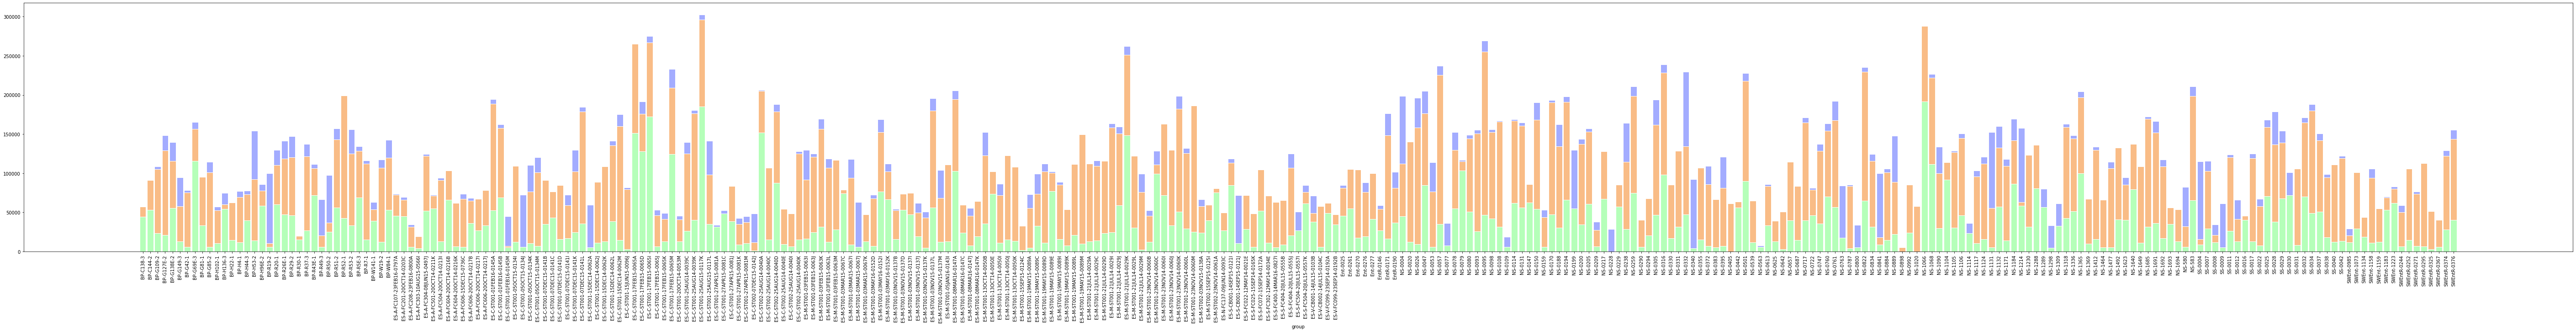

In [54]:
r = list(new_df['isolate'])        
greenBars = [i for i in new_df['greenBars']]
orangeBars = [i for i in new_df['orangeBars']]
blueBars = [i for i in new_df['blueBars']]
 
# plot
plt.figure(figsize=(100,10))
barWidth = 0.85
#names = sorted(list(common_isolates))
names = list(new_df['isolate'])
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names,rotation=90)
plt.xlabel("group")
 

#### Shared and unique contigs sorted in increasing order of total length

Text(0.5, 0, 'sorted')

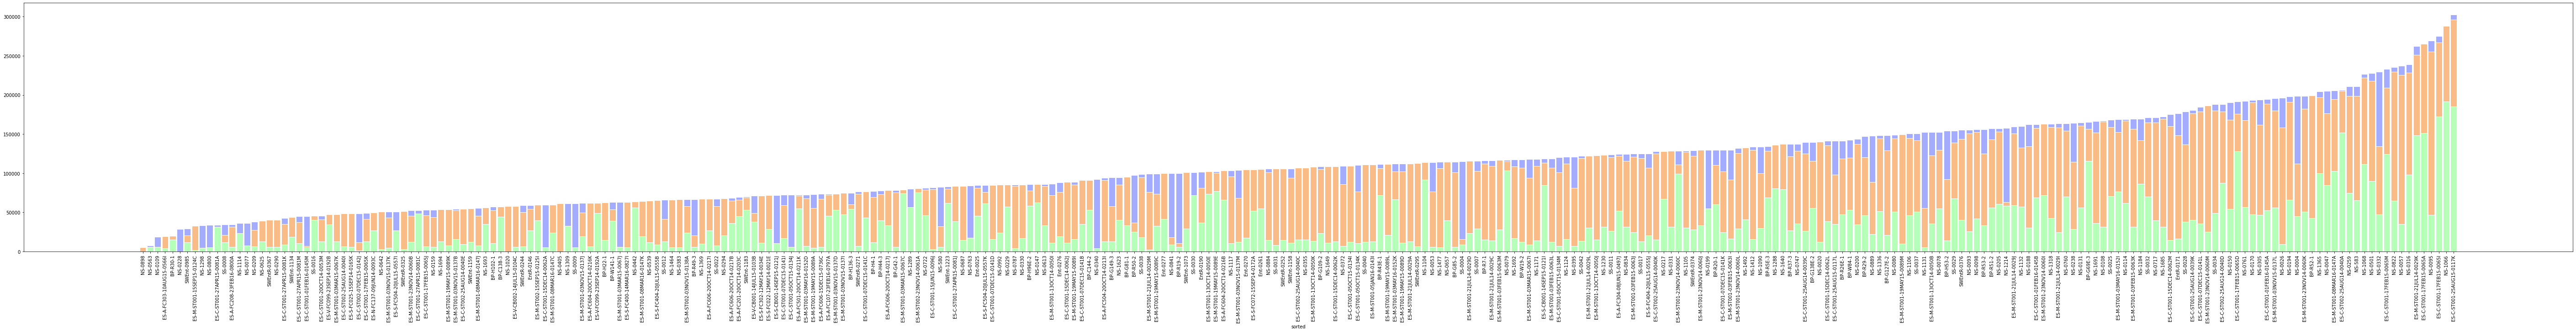

In [55]:
sorted_df = new_df.sort_values(by=['totals'])

r = list(sorted_df['isolate'])
greenBars = [i for i in sorted_df['greenBars']]
orangeBars = [i for i in sorted_df['orangeBars']]
blueBars = [i for i in sorted_df['blueBars']]
 
# plot
plt.figure(figsize=(100,10))
barWidth = 0.85
#names = sorted(list(common_isolates))
names = list(sorted_df['isolate'])
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names,rotation=90)
plt.xlabel("sorted")


Note: The following isolates were left from the above graphs as they were anomalies with very high total lengths relative to other isolates.

In [52]:
long_isolates

,isolate,greenBars,orangeBars,blueBars,totals
58,ES-C-ST001-07DEC15-0141J,1370915,148245,20512,1539672
295,SS-0039,184,67582,2890633,2958399


# Results

The results indicate that both the tools tend to agree with each other's results for the most part. However, there are a few instances where the sets of contigs from the two solutions are mutually exclusive.

In [58]:
results_folder = '../results'
score_dict = {}
count = 0
for file in os.listdir(results_folder):
    isolate_id = file.split("_")[0]
    filename = os.path.join(results_folder, file)
    str_list = read_file(filename)
    score = float(str_list[1].split("\t")[2])
    
    
    #score_dict[isolate_id]['H_len'] = 1
    if isolate_id in contig_lengths:
        if contig_lengths[isolate_id]['T'] <= 1000000:
            score_dict[isolate_id] = {}
            score_dict[isolate_id]['Score'] = score
            score_dict[isolate_id]['H_len'] = contig_lengths[isolate_id]['H']
            score_dict[isolate_id]['M_len'] = contig_lengths[isolate_id]['M']
            score_dict[isolate_id]['T_len'] = contig_lengths[isolate_id]['T']

In [59]:
score_dict = dict(sorted(score_dict.items()))
score_df = pd.DataFrame.from_dict(score_dict, orient='index')
#df = pd.DataFrame.from_dict(e, orient='index')

<Figure size 432x288 with 0 Axes>

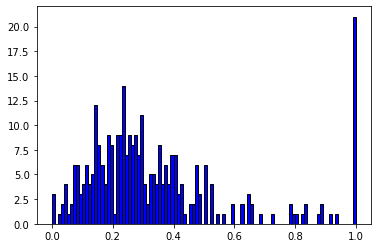

<Figure size 432x288 with 0 Axes>

In [60]:
plt.hist(score_df['Score'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.figure()

### Dissimiliarity score vs contig lengths

The score tends to be closer to zero when the contig lengths are higher. On the other hand when the lengths are smaller they tend to disagree. The same trend is observed when the score is plotted against total length of HyAsP contigs, MOBsuite contigs and the overall length.

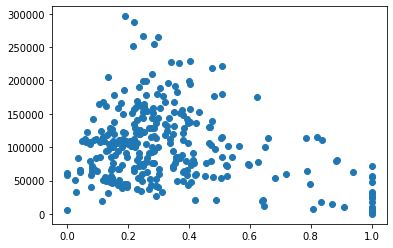

In [61]:
x = list(score_df['Score'])
y = list(score_df['H_len'])

plt.scatter(x, y)
#plt.xticks(r, names,rotation=90)
#plt.xlabel("group")
plt.show()

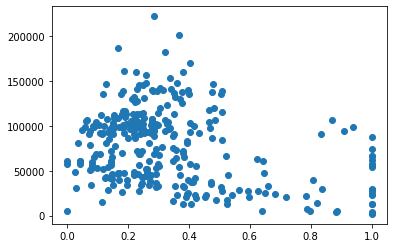

In [62]:
x = list(score_df['Score'])
y = list(score_df['M_len'])

plt.scatter(x, y)
#plt.xticks(r, names,rotation=90)
#plt.xlabel("group")
plt.show()

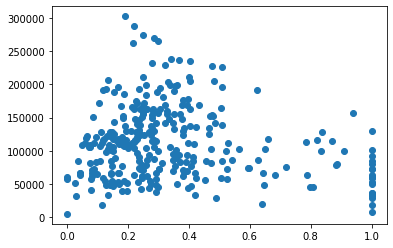

In [63]:
x = list(score_df['Score'])
y = list(score_df['T_len'])

plt.scatter(x, y)
#plt.xticks(r, names,rotation=90)
#plt.xlabel("group")
plt.show()